In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
import time
import sklearn
import tensorflow as tf
from tensorflow import keras
import pandas as pd

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,  sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
# datasets 存储在home/.keras/datasets/
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [9]:
# 对数据进行标准化 (x - u) /std
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1, 28,28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28, 28)


In [11]:
# tf.keras.models.Sequential()
# selu自带归一化，速度上会快一点比bn
# AlphaDropout: 1. 均值和方差不变; 2. 归一化性质也不变
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation = "selu"))
model.add(keras.layers.AlphaDropout(rate = 0.5))
# model.add(keras.layers.Dropout(rate = 0.5))
model.add(keras.layers.Dense(10, activation = "softmax"))

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [13]:
# callbacks(TensorBoard, EarlyStopping, ModelCheckpoint)
# tensorboard --logdir callbacks
logdir = './dnn-bn-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-3),
]

history = model.fit(x_train_scaled, y_train, epochs = 10, validation_data = [x_valid_scaled, y_valid], callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.6927 - accuracy: 0.7637 - val_loss: 0.6358 - val_accuracy: 0.8444
Epoch 2/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.4609 - accuracy: 0.8419 - val_loss: 0.6811 - val_accuracy: 0.8280
Epoch 3/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.4056 - accuracy: 0.8567 - val_loss: 0.6321 - val_accuracy: 0.8496
Epoch 4/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.3731 - accuracy: 0.8689 - val_loss: 0.5006 - val_accuracy: 0.8742
Epoch 5/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.3511 - accuracy: 0.8760 - val_loss: 0.5518 - val_accuracy: 0.8664
Epoch 6/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3334 - accuracy: 0.8816 - val_loss: 0.4884 - val_accuracy: 0.8730
Epoch 7/10
55000/55000 [==============================]

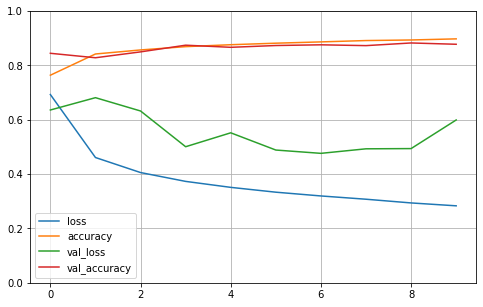

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize = (8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)
# 学习曲线前期平缓的原因：
# 1.参数众多，训练不充分
# 2. 梯度消失->链式法则-> 复合函数f(g(x))对其求导的时候值很小
# 批归一化可以缓解梯度消失

In [15]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 0s 42us/sample - loss: 0.6580 - accuracy: 0.8687


[0.6580444296896457, 0.8687]